In [ ]:
cd ../..

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from src.agents import load_saved_experiment, obtain_cfes
from src.utils import plot_signal
from matplotlib.lines import Line2D

In [2]:
EXP1_RESULTS_DIR = os.path.join("old_results", "experiment_1")
exp1_results = pd.read_excel(os.path.join(EXP1_RESULTS_DIR, "experiments.xlsx"))
exp1_results = exp1_results[
    (exp1_results["weights_losses"] == "[1, 1, 1, 0]")
    & (exp1_results["super_head"] == True)
    & (exp1_results["mapping_mode"] != "triangular")
    & (exp1_results["mapping_mode"] != "value")
]
exp1_results.drop(
    [
        "start",
        "algorithm",
        "ones_mask",
        "timesteps",
        "total_time",
        "weights_losses",
        "super_head",
        "valid",
    ],
    axis=1,
    inplace=True,
)
exp1_results["dataset"] = pd.Categorical(
    exp1_results["dataset"],
    categories=["chinatown", "ecg200", "gunpoint", "beef"],
    ordered=True,
)
exp1_results = exp1_results.sort_values(by=["dataset", "mapping_mode"])
exp1_results["gamma"] = (
    [0, 0.2, 0.5, 0.7, 0.99]
    * len(exp1_results["dataset"].unique())
    * len(exp1_results["mapping_mode"].unique())
)
exp1_results = exp1_results[
    (exp1_results["gamma"] != 0)
    & (exp1_results["gamma"] != 0.2)
    & (exp1_results["gamma"] != 0.99)
]
exp1_results

,hash,dataset,mapping_mode,reward,step,proba,subsequences,num_changes,perc_changes,L1,L2,improvement_nun,gamma
23,058b0a35c589,chinatown,default,0.01 ± 0.03,1.29 ± 1.29,0.97 ± 0.06,2.13 ± 0.58,7.17 ± 0.87,0.30 ± 0.04,2.23 ± 0.54,0.99 ± 0.21,0.19 ± 0.03,0.5
399,7b4104e0e80e,chinatown,default,-0.03 ± 0.01,1.95 ± 0.22,0.99 ± 0.02,2.95 ± 0.22,9.15 ± 0.66,0.38 ± 0.03,2.92 ± 0.58,1.13 ± 0.20,0.15 ± 0.01,0.7
71,8d47a843e343,chinatown,steps,-0.01 ± 0.01,2.00 ± 0.25,0.98 ± 0.03,2.01 ± 0.10,9.12 ± 0.73,0.38 ± 0.03,2.90 ± 0.90,1.12 ± 0.28,0.17 ± 0.01,0.5
431,41e083d978d5,chinatown,steps,-0.01 ± 0.01,2.01 ± 0.17,0.99 ± 0.01,2.02 ± 0.14,9.09 ± 0.57,0.38 ± 0.02,2.87 ± 0.58,1.12 ± 0.23,0.17 ± 0.01,0.7
119,caa3af719dc6,ecg200,default,0.00 ± 0.06,6.04 ± 6.20,0.94 ± 0.07,3.78 ± 2.16,39.81 ± 12.70,0.41 ± 0.13,20.30 ± 8.02,4.23 ± 1.14,0.13 ± 0.06,0.5
463,ed6c52e5fd68,ecg200,default,-0.03 ± 0.05,2.40 ± 0.83,0.91 ± 0.11,3.40 ± 0.83,46.43 ± 16.45,0.48 ± 0.17,23.61 ± 8.58,4.60 ± 1.20,0.10 ± 0.05,0.7
167,c099a1b6bfc0,ecg200,steps,-0.04 ± 0.03,0.98 ± 0.32,0.96 ± 0.07,1.94 ± 0.24,60.60 ± 9.13,0.63 ± 0.10,30.13 ± 12.75,5.10 ± 1.71,0.09 ± 0.03,0.5
495,768d0dbfc861,ecg200,steps,-0.05 ± 0.02,1.79 ± 0.67,0.98 ± 0.04,1.80 ± 0.53,65.76 ± 7.17,0.68 ± 0.07,30.98 ± 11.53,5.08 ± 1.66,0.08 ± 0.02,0.7
215,bc0e969c37a4,gunpoint,default,-0.08 ± 0.02,2.14 ± 0.73,0.97 ± 0.08,1.99 ± 0.10,122.65 ± 19.89,0.82 ± 0.13,28.51 ± 15.28,3.46 ± 1.71,0.03 ± 0.02,0.5
527,acb25abed722,gunpoint,default,-0.02 ± 0.03,3.13 ± 1.52,0.95 ± 0.05,2.45 ± 1.17,90.84 ± 24.89,0.61 ± 0.17,22.11 ± 13.43,3.10 ± 1.79,0.09 ± 0.03,0.7


In [3]:
EXP2_RESULTS_DIR = os.path.join("old_results", "exp2_1M_timesteps_dqn")
exp2_results = pd.read_excel(os.path.join(EXP2_RESULTS_DIR, "experiments.xlsx"))
exp2_results.drop(
    [
        "algorithm",
        "super_head",
        "start",
        "total_time",
        "ones_mask",
        "weights_losses",
        "timesteps",
        "valid",
    ],
    axis=1,
    inplace=True,
)
exp2_results["gamma"] = (
    [0.5, 0.7]
    * len(exp2_results["dataset"].unique())
    * len(exp2_results["mapping_mode"].unique())
)
exp2_results

,hash,dataset,mapping_mode,reward,step,proba,subsequences,num_changes,perc_changes,L1,L2,improvement_nun,gamma
0,a0c72971ade5,chinatown,default,-0.06 ± 0.02,3.64 ± 0.94,0.98 ± 0.05,2.00 ± 0.00,12.72 ± 1.88,0.53 ± 0.08,3.79 ± 0.90,1.28 ± 0.28,0.12 ± 0.02,0.5
1,a15dd47e6640,chinatown,default,0.02 ± 0.05,9.27 ± 3.37,0.93 ± 0.07,2.02 ± 0.35,5.55 ± 3.10,0.23 ± 0.13,2.31 ± 0.82,1.09 ± 0.28,0.20 ± 0.05,0.7
2,1d406d404ced,chinatown,steps,-0.16 ± 0.02,0.78 ± 0.98,0.98 ± 0.03,1.39 ± 0.49,21.27 ± 3.43,0.89 ± 0.14,5.31 ± 1.19,1.48 ± 0.33,0.02 ± 0.02,0.5
3,4c610e5fe506,chinatown,steps,-0.10 ± 0.03,2.64 ± 0.48,0.98 ± 0.04,2.00 ± 0.00,15.20 ± 2.41,0.63 ± 0.10,4.43 ± 1.04,1.39 ± 0.31,0.08 ± 0.03,0.7
4,cd39e4835d8a,ecg200,default,0.01 ± 0.09,6.70 ± 3.02,0.92 ± 0.11,2.05 ± 0.66,43.39 ± 25.97,0.45 ± 0.27,21.27 ± 10.25,4.22 ± 1.18,0.14 ± 0.09,0.5
5,5b098e395137,ecg200,default,-0.04 ± 0.07,10.61 ± 7.70,0.93 ± 0.09,3.09 ± 1.20,54.13 ± 25.10,0.56 ± 0.26,25.92 ± 11.61,4.65 ± 1.29,0.09 ± 0.07,0.7
6,33aecd851196,ecg200,steps,-0.05 ± 0.03,2.59 ± 0.73,0.96 ± 0.05,2.15 ± 0.39,63.51 ± 9.08,0.66 ± 0.09,30.67 ± 12.71,5.12 ± 1.74,0.07 ± 0.03,0.5
7,af7636c44f42,ecg200,steps,-0.11 ± 0.02,1.63 ± 1.97,0.99 ± 0.02,1.48 ± 0.50,86.36 ± 10.25,0.90 ± 0.11,36.63 ± 9.75,5.31 ± 1.26,0.02 ± 0.02,0.7
8,e4673365e8f5,gunpoint,default,-0.01 ± 0.02,4.45 ± 3.30,0.96 ± 0.05,3.40 ± 1.45,79.49 ± 12.86,0.53 ± 0.09,19.94 ± 11.46,3.04 ± 1.68,0.10 ± 0.02,0.5
9,d77554ea7bab,gunpoint,default,0.00 ± 0.04,2.45 ± 1.69,0.95 ± 0.06,2.01 ± 0.63,81.78 ± 21.48,0.55 ± 0.14,21.53 ± 11.65,3.32 ± 1.96,0.12 ± 0.04,0.7


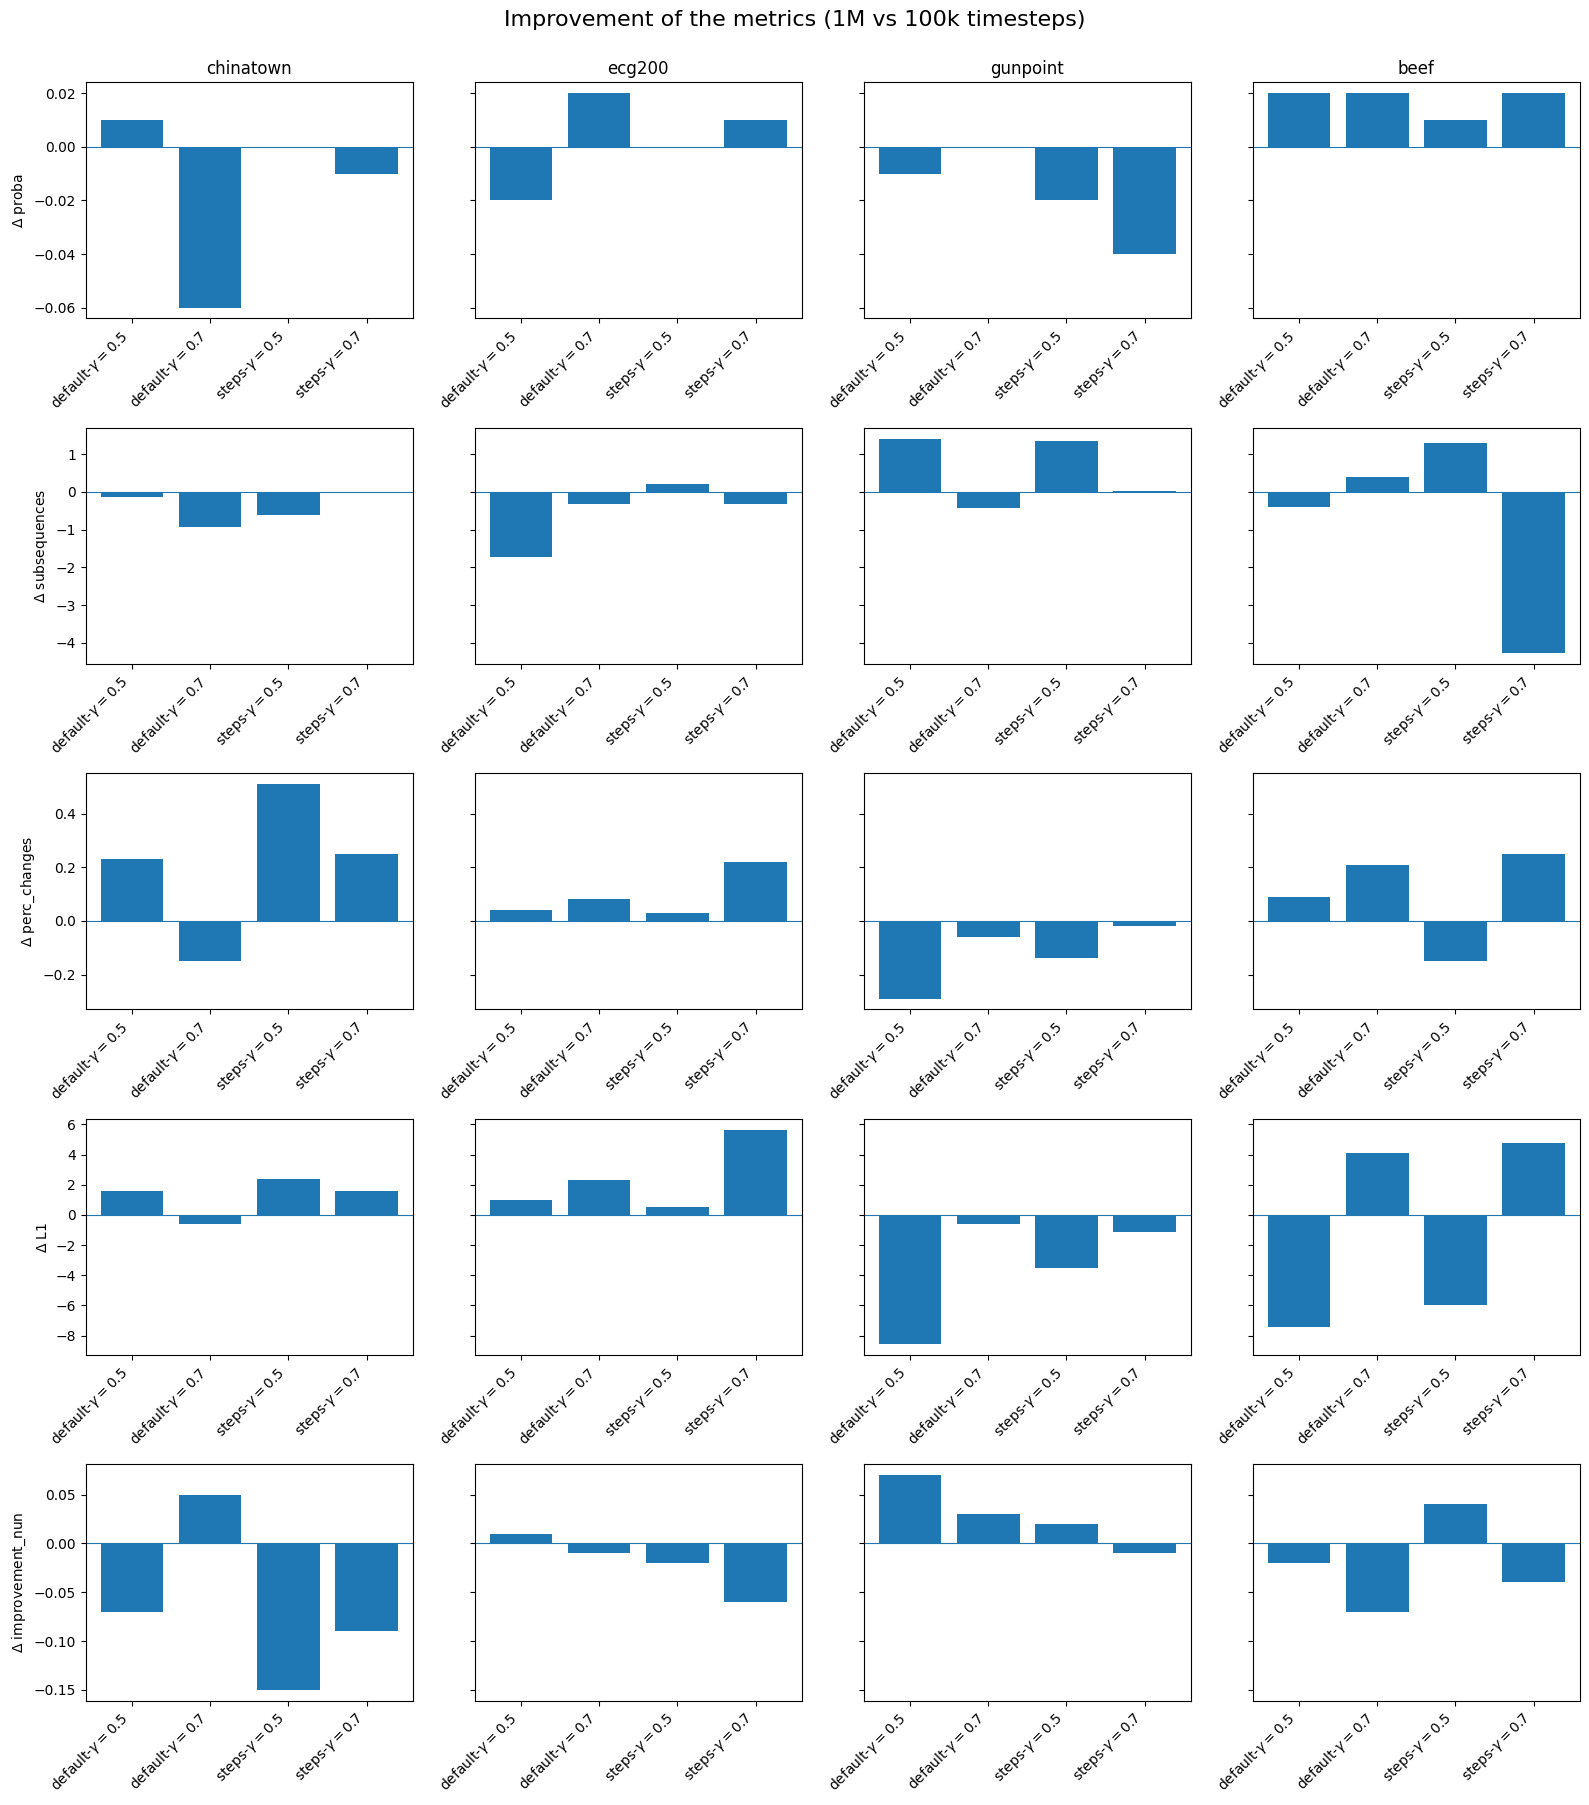

In [4]:
def parse_mean(value_str):
    """
    Parsea una cadena tipo 'μ ± σ' y devuelve el valor medio (μ) como float.
    Si no coincide, intenta convertir directamente a float.
    """
    if isinstance(value_str, str):
        match = re.match(r"\s*([-\d\.]+)\s*±", value_str)
        if match:
            return float(match.group(1))
    try:
        return float(value_str)
    except:
        return None


def compare_experiments(
    df_100k: pd.DataFrame, df_1M: pd.DataFrame, exclude_columns: list = None
) -> pd.DataFrame:
    """
    Compara las métricas (parsando 'μ ± σ') entre dos DataFrames de resultados:
    - df_100k: resultados con 100k pasos
    - df_1M:   resultados con 1M pasos
    - exclude_columns: lista de columnas que no se analizarán

    Ambos DataFrames deben tener las columnas:
    ['dataset', 'mapping_mode', 'gamma', <métricas...>]
    con valores como strings 'μ ± σ'.

    Devuelve un DataFrame con:
    ['dataset', 'mapping_mode', 'gamma', 'metric', 'mean_100k', 'mean_1M', 'delta', 'pct_change']
    """
    # Columnas clave
    keys = ["dataset", "mapping_mode", "gamma"]
    # Inicializar lista de exclusión
    exclude_columns = exclude_columns or []
    # Métricas a comparar: todas menos claves y exclusiones
    metrics = [c for c in df_100k.columns if c not in keys + exclude_columns]

    # Parsar medias en cada DataFrame
    df1 = df_100k.copy()
    df2 = df_1M.copy()
    for df in (df1, df2):
        for m in metrics:
            df[f"{m}_mean"] = df[m].apply(parse_mean)

    # Reformatear a largo usando solo las métricas calculadas
    df1_long = df1.melt(
        id_vars=keys,
        value_vars=[f"{m}_mean" for m in metrics],
        var_name="metric",
        value_name="mean_100k",
    )
    df2_long = df2.melt(
        id_vars=keys,
        value_vars=[f"{m}_mean" for m in metrics],
        var_name="metric",
        value_name="mean_1M",
    )

    # Unificar nombres de métrica
    df1_long["metric"] = df1_long["metric"].str.replace("_mean", "", regex=False)
    df2_long["metric"] = df2_long["metric"].str.replace("_mean", "", regex=False)

    # Merge y cálculo de delta y cambio porcentual
    df_comp = pd.merge(df1_long, df2_long, on=keys + ["metric"])
    df_comp["delta"] = df_comp["mean_1M"] - df_comp["mean_100k"]
    df_comp["pct_change"] = df_comp.apply(
        lambda row: (
            (row["delta"] / abs(row["mean_100k"]) * 100)
            if row["mean_100k"] not in (0, None)
            else None
        ),
        axis=1,
    )

    return df_comp


def plot_metrics_deltas_grid(df_comp: pd.DataFrame, metrics: list):
    """
    Para cada métrica en `metrics` crea una fila de subplots (uno por dataset),
    mostrando el delta (1M - 100k) para cada combinación de mapping_mode y gamma.
    """
    # Datasets fijos (columnas)
    datasets = df_comp["dataset"].unique()
    n_rows = len(metrics)
    n_cols = len(datasets)

    # Crear grid de subplots
    fig, axes = plt.subplots(
        nrows=n_rows, ncols=n_cols, figsize=(4 * n_cols, 4 * n_rows), sharey="row"
    )

    # Asegurarnos que axes sea siempre array 2D
    if n_rows == 1 and n_cols == 1:
        axes = np.array([[axes]])
    elif n_rows == 1:
        axes = np.array([axes])
    elif n_cols == 1:
        axes = np.array([[ax] for ax in axes])

    # Iterar por filas y columnas
    for i, metric in enumerate(metrics):
        sub = df_comp[df_comp["metric"] == metric]
        for j, ds in enumerate(datasets):
            ax = axes[i, j]
            data_ds = sub[sub["dataset"] == ds]

            # Preparar etiquetas y valores
            labels = (
                data_ds["mapping_mode"] + "-$\gamma=$" + data_ds["gamma"].astype(str)
            )
            values = data_ds["delta"]
            pos = range(len(labels))

            ax.bar(pos, values)
            ax.set_xticks(pos)
            ax.set_xticklabels(labels, rotation=45, ha="right")
            if j == 0:
                ax.set_ylabel(f"$\\Delta$ {metric}")
            if i == 0:
                ax.set_title(ds)
            ax.axhline(0, linewidth=0.8)

    # Títulos y ajuste de layout
    fig.suptitle(
        "Improvement of the metrics (1M vs 100k timesteps)", y=0.9, fontsize=16
    )
    fig.tight_layout(rect=[0, 0, 1, 0.90])
    plt.show()


plot_metrics_deltas_grid(
    compare_experiments(
        exp1_results,
        exp2_results,
        exclude_columns=["hash"],  # "step", "reward", "num_changes", "L2"
    ),
    ["proba", "subsequences", "perc_changes", "L1", "improvement_nun"],
)  # Possible values for metric: "reward", "step", "proba", "subsequences", "num_changes", "perc_changes", "L1", "L2", "improvement_nun"

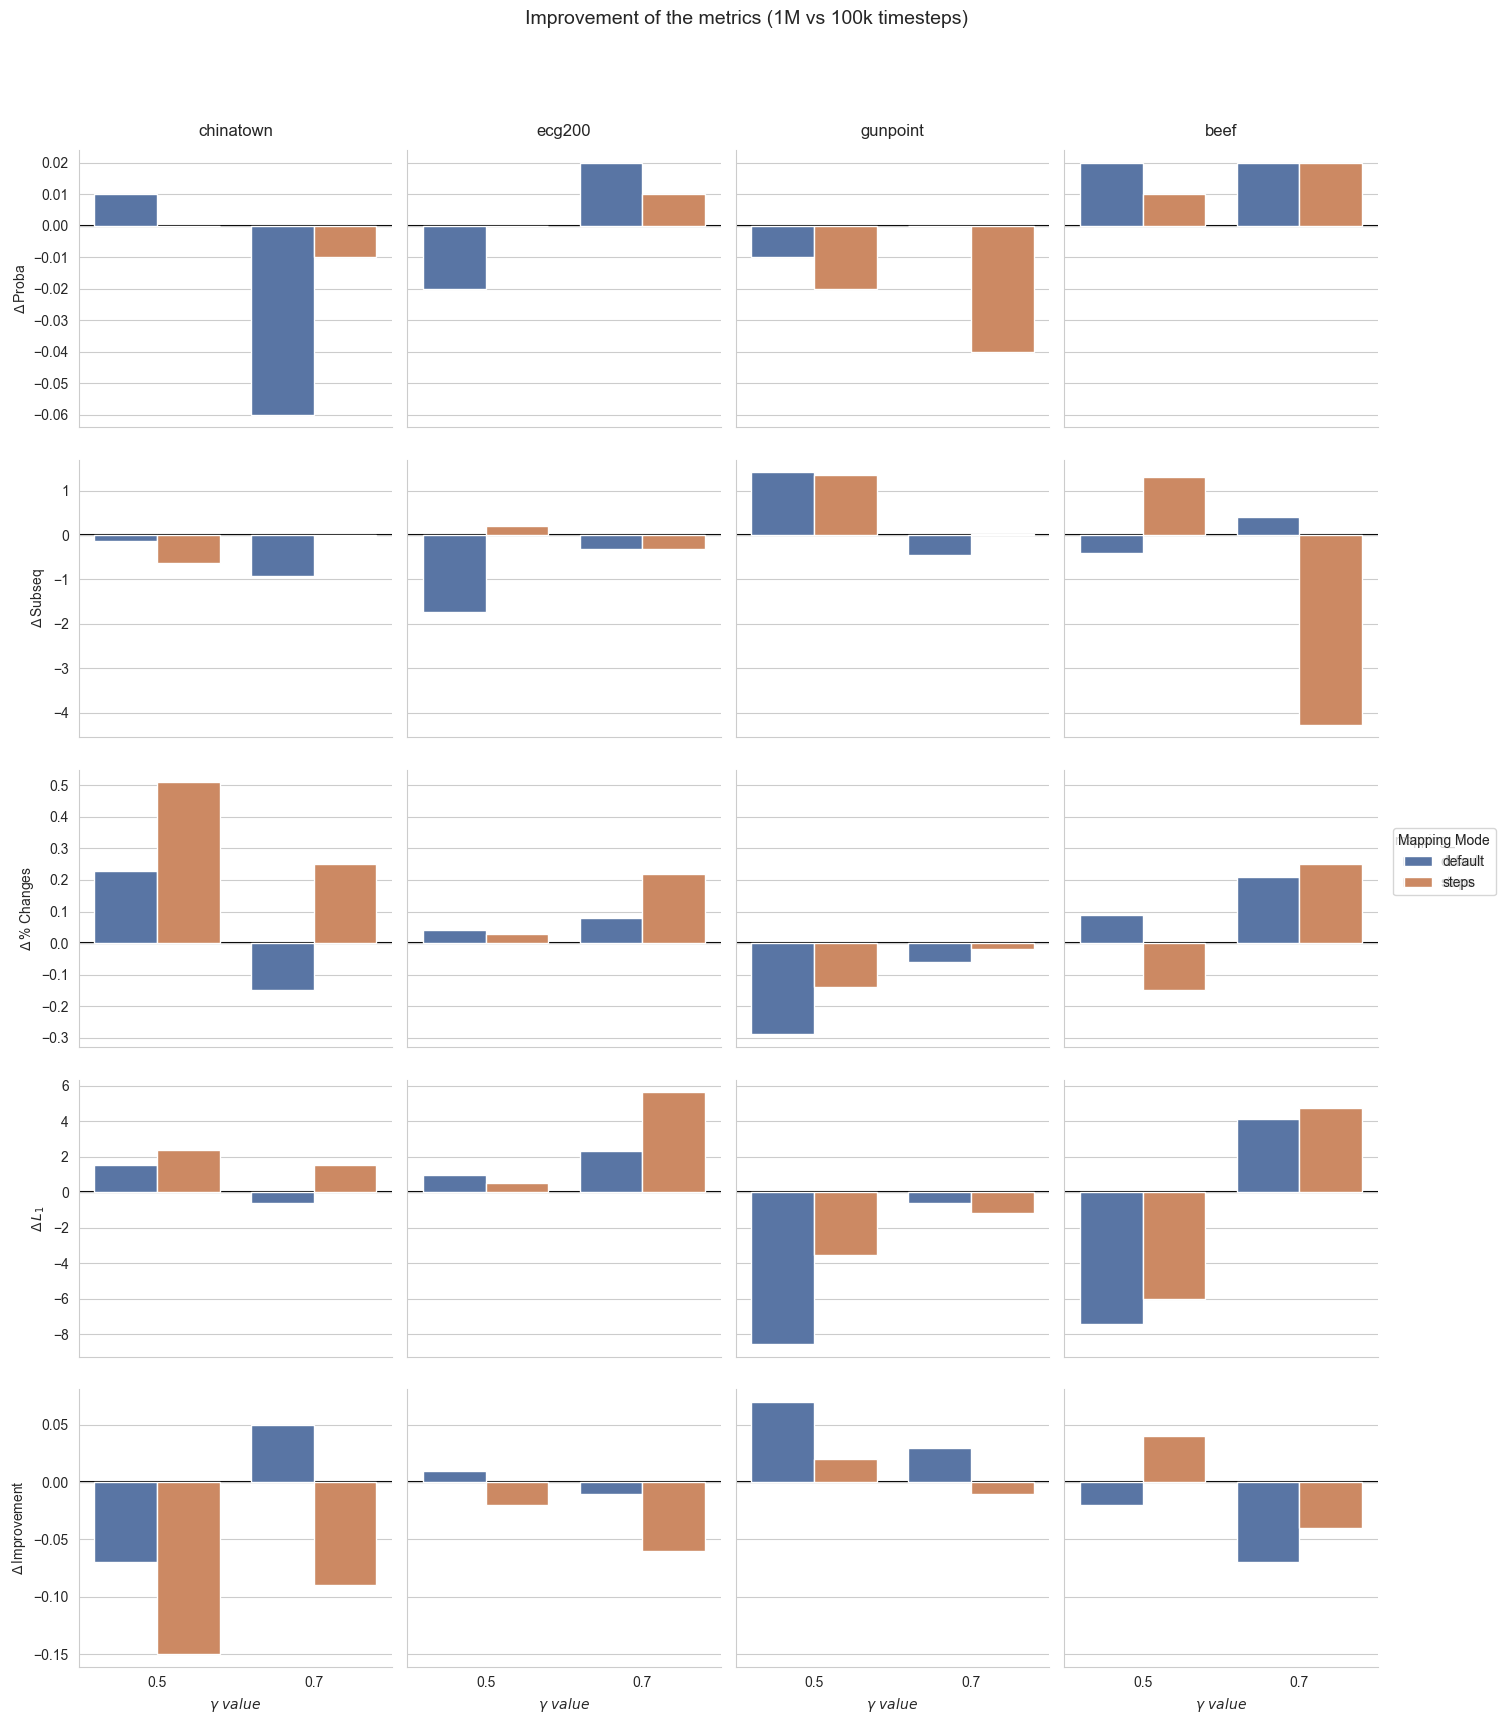

In [5]:
def plot_metrics_seaborn(df_comp, metrics):
    names = {
        "perc_changes": "% Changes",
        "subsequences": "Subseq",
        "proba": "Proba",
        "L1": "$L_1$",
        "improvement_nun": "Improvement",
    }
    sub = df_comp[df_comp["metric"].isin(metrics)].copy()
    sub["metric_label"] = sub["metric"].map(names)
    row_labels = [names[m] for m in metrics]

    sns.set_style("whitegrid")
    g = sns.catplot(
        data=sub,
        x="gamma",
        y="delta",
        hue="mapping_mode",
        col="dataset",
        row="metric_label",
        row_order=row_labels,
        kind="bar",
        height=3.5,
        aspect=1.0,
        sharey="row",
        palette="deep",
    )

    n_rows, n_cols = len(row_labels), len(g.col_names)
    for j, ds in enumerate(g.col_names):
        ax = g.axes[0, j]
        ax.set_title(ds, pad=10)

    for i in range(1, n_rows):
        for j in range(n_cols):
            g.axes[i, j].set_title("")

    for i, label in enumerate(row_labels):
        ax = g.axes[i, 0]
        ax.set_ylabel(f"$\\Delta\\,${label}")

    g.set_xlabels("$\\gamma~value$")
    g.fig.legend(title="Mapping Mode", loc="center right")

    for ax in g.axes.flat:
        ax.axhline(0, color="k", linewidth=1.5, zorder=0)

    g.fig.subplots_adjust(top=0.9)
    g.fig.suptitle("Improvement of the metrics (1M vs 100k timesteps)", fontsize=14)
    plt.show()


plot_metrics_seaborn(
    compare_experiments(
        exp1_results,
        exp2_results,
        exclude_columns=["hash"],  # "step", "reward", "num_changes", "L2"
    ),
    ["proba", "subsequences", "perc_changes", "L1", "improvement_nun"],
)

In [6]:
gamma_selected = 0.7
mapping_selected = "default"

exp1_selected = exp1_results[
    (exp1_results.gamma == gamma_selected)
    & (exp1_results.mapping_mode == mapping_selected)
]
exp2_selected = exp2_results[
    (exp2_results.gamma == gamma_selected)
    & (exp2_results.mapping_mode == mapping_selected)
]

Agent loaded successfully from old_results\experiment_1\7b4104e0e80e\model.zip
Agent loaded successfully from old_results\exp2_1M_timesteps_dqn\a15dd47e6640\model.zip
Agent loaded successfully from old_results\experiment_1\ed6c52e5fd68\model.zip
Agent loaded successfully from old_results\exp2_1M_timesteps_dqn\5b098e395137\model.zip
Agent loaded successfully from old_results\experiment_1\acb25abed722\model.zip
Agent loaded successfully from old_results\exp2_1M_timesteps_dqn\d77554ea7bab\model.zip
Agent loaded successfully from old_results\experiment_1\531a5a0295cc\model.zip
Agent loaded successfully from old_results\exp2_1M_timesteps_dqn\2304f2593ec6\model.zip


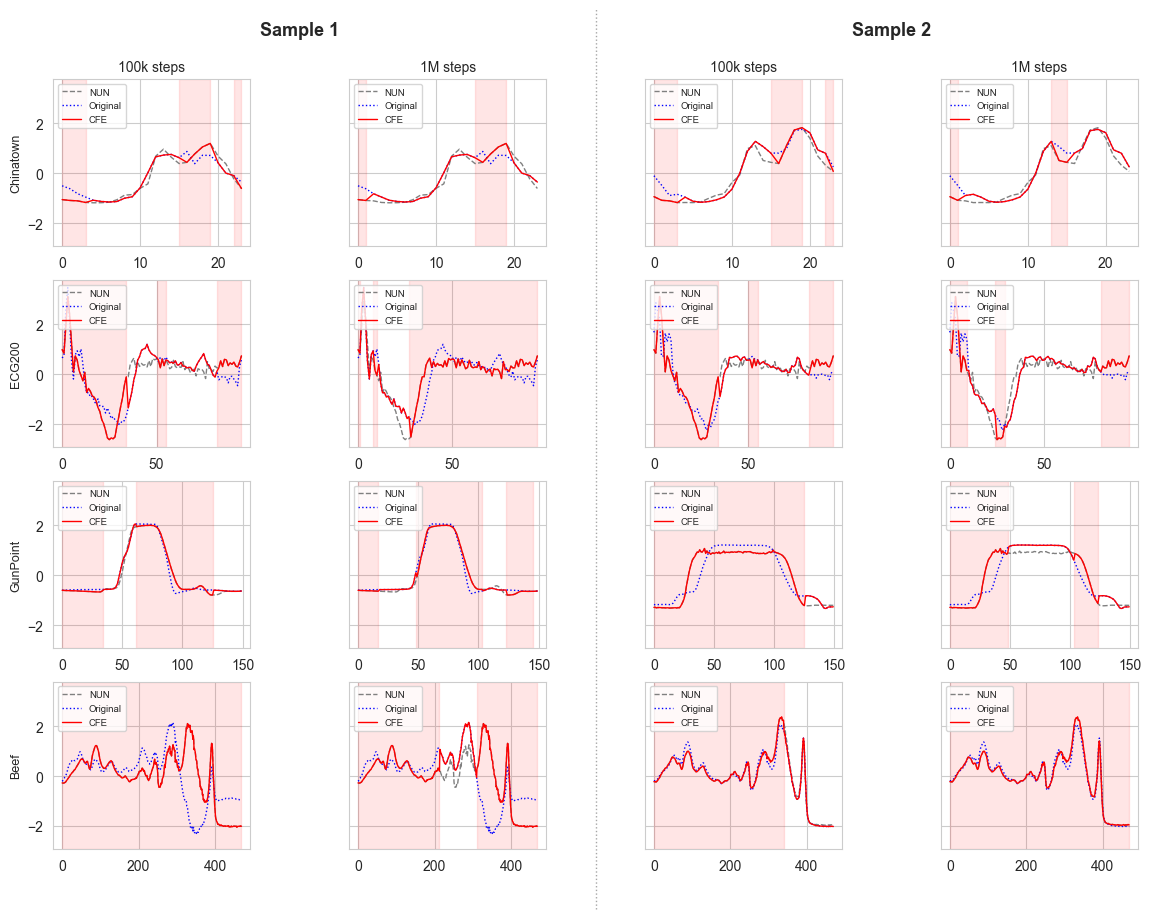

In [7]:
index_selected1 = 4
index_selected2 = 9
datasets = ["Chinatown", "ECG200", "GunPoint", "Beef"]

fig, axes = plt.subplots(
    len(exp1_selected), 4, figsize=(14, 10), sharey=True, gridspec_kw={"wspace": 0.5}
)

for i in range(len(exp1_selected)):
    # --- Experiment 1 (100k) ---
    exp1_hash = exp1_selected.iloc[i]["hash"]
    agent1, env1, data1 = load_saved_experiment(exp1_hash, directory=EXP1_RESULTS_DIR)

    orig11 = data1.get_sample(index=index_selected1)
    label11 = data1.y_train_model[index_selected1]
    nun11 = data1.get_nun(sample_index=index_selected1)
    cfe_info11 = obtain_cfes([orig11], [label11], [nun11], env=env1, agent=agent1)[0]

    orig12 = data1.get_sample(index=index_selected2)
    label12 = data1.y_train_model[index_selected2]
    nun12 = data1.get_nun(sample_index=index_selected2)
    cfe_info12 = obtain_cfes([orig12], [label12], [nun12], env=env1, agent=agent1)[0]

    # --- Experiment 2 (1M) ---
    exp2_hash = exp2_selected.iloc[i]["hash"]
    agent2, env2, data2 = load_saved_experiment(exp2_hash, directory=EXP2_RESULTS_DIR)

    orig21 = data2.get_sample(index=index_selected1)
    label21 = data2.y_train_model[index_selected1]
    nun21 = data2.get_nun(sample_index=index_selected1)
    cfe_info21 = obtain_cfes([orig21], [label21], [nun21], env=env2, agent=agent2)[0]

    orig22 = data2.get_sample(index=index_selected2)
    label22 = data2.y_train_model[index_selected2]
    nun22 = data2.get_nun(sample_index=index_selected2)
    cfe_info22 = obtain_cfes([orig22], [label22], [nun22], env=env2, agent=agent2)[0]

    plot_signal(X=orig11, X2=nun11, mask=cfe_info11["mask"], ax=axes[i, 0])
    plot_signal(X=orig21, X2=nun21, mask=cfe_info21["mask"], ax=axes[i, 1])
    plot_signal(X=orig12, X2=nun12, mask=cfe_info12["mask"], ax=axes[i, 2])
    plot_signal(X=orig22, X2=nun22, mask=cfe_info22["mask"], ax=axes[i, 3])

    axes[i, 0].set_ylabel(f"{datasets[i]}", fontsize=9)
    for ax in axes[i, :]:
        ax.set_title("")

axes[0, 0].set_title("100k steps", fontsize=10)
axes[0, 1].set_title("1M steps", fontsize=10)
axes[0, 2].set_title("100k steps", fontsize=10)
axes[0, 3].set_title("1M steps", fontsize=10)

pos_left_start = axes[0, 0].get_position().x0
pos_left_end   = axes[0, 1].get_position().x1
center_left    = (pos_left_start + pos_left_end) / 2

pos_right_start = axes[0, 2].get_position().x0
pos_right_end   = axes[0, 3].get_position().x1
center_right    = (pos_right_start + pos_right_end) / 2

fig.text(center_left, 0.92, "Sample 1", ha="center", va="bottom", fontsize=13, fontweight="bold")
fig.text(center_right, 0.92, "Sample 2", ha="center", va="bottom", fontsize=13, fontweight="bold")

# handles, labels = axes[0, 0].get_legend_handles_labels()
# fig.legend(handles, labels, loc='upper center', ncol=3, fontsize=10)

fig.canvas.draw()
pos1 = axes[0, 1].get_position()
pos2 = axes[0, 2].get_position()
x_sep = (pos1.x1 + pos2.x0) / 2

line = Line2D(
    [x_sep, x_sep],
    [0.05, 0.95],
    transform=fig.transFigure,
    color="gray",
    linewidth=1,
    linestyle=":",
    alpha=0.7
)
fig.add_artist(line)

plt.show()

---

### `step` metric analysis

In [8]:
print(exp2_results[["hash", "dataset", "mapping_mode", "gamma", "step", "improvement_nun"]])

            hash    dataset mapping_mode  gamma          step improvement_nun
0   a0c72971ade5  chinatown      default    0.5   3.64 ± 0.94     0.12 ± 0.02
1   a15dd47e6640  chinatown      default    0.7   9.27 ± 3.37     0.20 ± 0.05
2   1d406d404ced  chinatown        steps    0.5   0.78 ± 0.98     0.02 ± 0.02
3   4c610e5fe506  chinatown        steps    0.7   2.64 ± 0.48     0.08 ± 0.03
4   cd39e4835d8a     ecg200      default    0.5   6.70 ± 3.02     0.14 ± 0.09
5   5b098e395137     ecg200      default    0.7  10.61 ± 7.70     0.09 ± 0.07
6   33aecd851196     ecg200        steps    0.5   2.59 ± 0.73     0.07 ± 0.03
7   af7636c44f42     ecg200        steps    0.7   1.63 ± 1.97     0.02 ± 0.02
8   e4673365e8f5   gunpoint      default    0.5   4.45 ± 3.30     0.10 ± 0.02
9   d77554ea7bab   gunpoint      default    0.7   2.45 ± 1.69     0.12 ± 0.04
10  79fba6c9dc12   gunpoint        steps    0.5   5.33 ± 2.96     0.09 ± 0.03
11  edef9c3f52ba   gunpoint        steps    0.7   3.15 ± 2.81   

In [9]:
agent, env, data = load_saved_experiment("5b098e395137", directory=EXP2_RESULTS_DIR)

Agent loaded successfully from old_results\exp2_1M_timesteps_dqn\5b098e395137\model.zip


In [10]:
samples, labels, nuns = data.get_test_samples()
sample = samples[8]
label = labels[8]
nun = nuns[8]

observation, _ = env.reset(sample, nun)
done, end = False, False
mask_evolution = {0: observation['mask'].copy()}
steps_evolution = {}
best_reward, best_reward_step = 0, 0
while not done and not end:
    action, _ = agent.predict(observation, deterministic=True)
    start, size = env.action(action)
    observation, reward, done, end, info = env.step(action)
    mask_evolution[info['step']] = info['mask'].copy()
    steps_evolution[info['step']] = (int(start), int(size))
    if reward > best_reward:
        best_reward = reward
        best_reward_step = info['step']

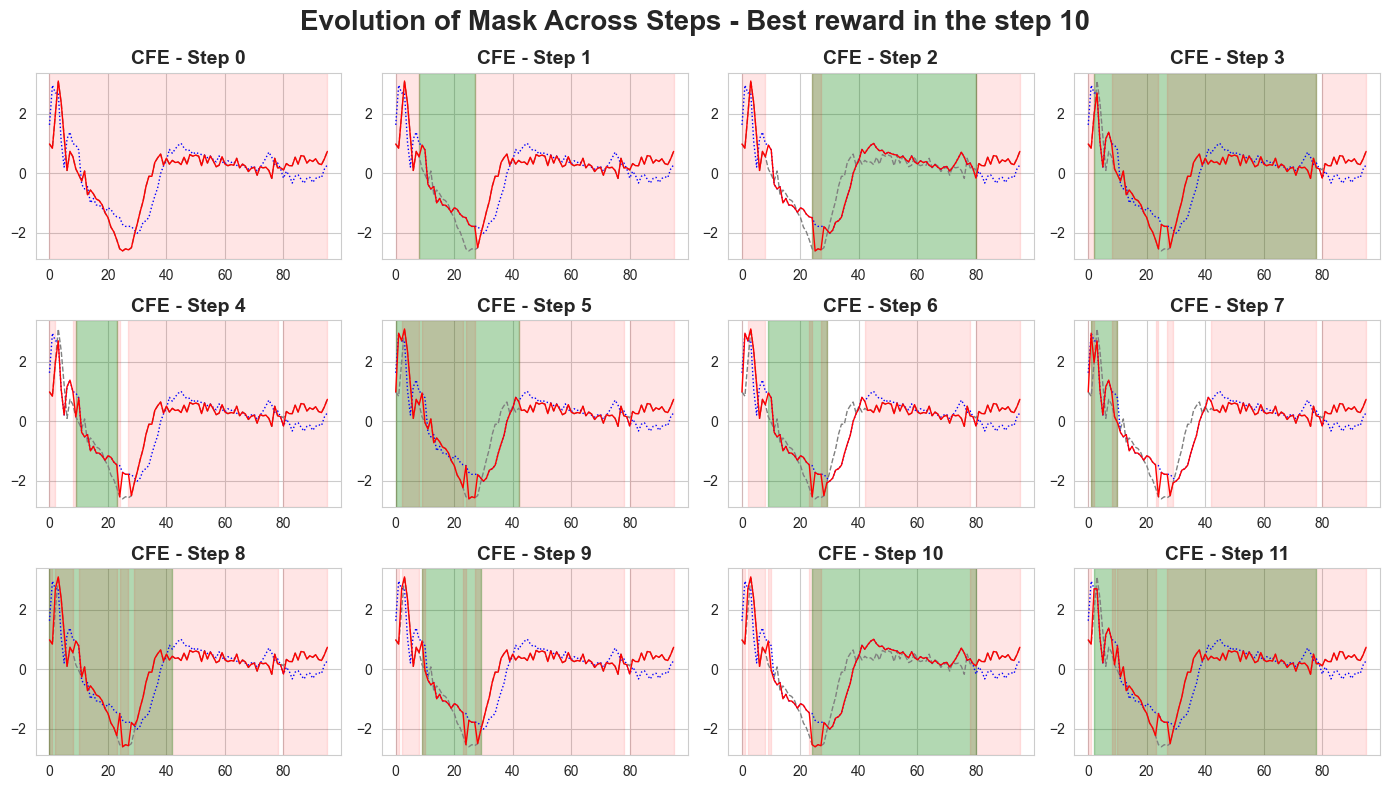

In [11]:
fig, axes = plt.subplots(3, 4, figsize=(14, 8))
cfe_info = env.get_cfe()

for i in range(12):
    row = i // 4
    col = i % 4
    ax = axes[row, col]
    
    mask = mask_evolution[i]
    plot_signal(X=sample, X2=nun, mask=mask, title=f"Step {i}", ax=ax, legend=False, changes=steps_evolution.get(i, None))

fig.suptitle(f"Evolution of Mask Across Steps - Best reward in the step {cfe_info['step']}", fontsize=20, fontweight='bold')
plt.tight_layout()
plt.show()